In [ ]:
#!pip install transformers==4.19.2
!pip install torch==1.4.0
!pip install --upgrade diffusers[torch]
!pip install git+https://github.com/huggingface/transformers
!pip install accelerate scipy safetensors
!pip install ftfy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement torch==1.4.0 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1)
ERROR: No matching distribution found for torch==1.4.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-lebblk15
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-lebblk15
  Resolved https://github.com/huggingface/transformers to commit 233113149b02756460fe07cfc047aff1d9c7dfeb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, http

In [ ]:
from PIL import Image, ImageEnhance

def add_white_background(png_image_path, output_image_path):
    # Open the PNG image
    png_image = Image.open(png_image_path).convert("RGBA")

    # Create a new white background image with the same size as the PNG image
    background_image = Image.new("RGBA", png_image.size, (255, 255, 255, 255))

    # Create a new image with the white background as the base
    new_image = Image.alpha_composite(background_image, png_image)

    # Save the resulting image
    new_image.save(output_image_path)

def add_white_pixels(png_image_path, output_image_path, padding):
    # Open the PNG image
    png_image = Image.open(png_image_path).convert("RGBA")

    # Calculate the new size of the image with added padding
    new_width = png_image.width + 2 * padding
    new_height = png_image.height + 2 * padding

    # Create a new white image with the larger size
    new_image = Image.new("RGBA", (new_width, new_height), (255, 255, 255, 255))

    # Calculate the position to paste the original image with padding
    position = (padding, padding)

    # Paste the original image onto the new image with padding
    new_image.paste(png_image, position)

    # Save the resulting image
    new_image.save(output_image_path)



# Example usage: Adding a white background
add_white_background("perfume-png-transparent-images-png-only-12.png", "output.png")

# Example usage: Adding white pixels with a padding of 900
add_white_pixels("output.png", "output.png", 900)


In [ ]:
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
import torch

def convert_png_to_jpg(png_image_path, jpg_image_path):
    # Open the PNG image
    png_image = Image.open(png_image_path)

    # Convert the PNG image to RGB mode (if it's not already)
    png_image = png_image.convert("RGB")

    # Save the image as a JPEG
    png_image.save(jpg_image_path, "JPEG")

# Example usage
convert_png_to_jpg("output.png", "image.jpg")

# Load Mask2Former trained on COCO instance segmentation dataset
image_processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-ade-semantic")
model = Mask2FormerForUniversalSegmentation.from_pretrained(
    "facebook/mask2former-swin-large-ade-semantic"
)

image = Image.open("image.jpg")
inputs = image_processor(image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

# Model predicts class_queries_logits of shape `(batch_size, num_queries)`
# and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits

# Perform post-processing to get instance segmentation map
pred_instance_map = image_processor.post_process_semantic_segmentation(
    outputs, target_sizes=[image.size[::-1]]
)[0]
print(pred_instance_map.shape)

torch.Size([3800, 3225])


In [ ]:
import numpy as np
np.unique(pred_instance_map.numpy(), return_counts=True)

(array([ 2,  4, 84]), array([10854847,  1211858,   188295]))

In [ ]:
masked_im =pred_instance_map.numpy()
masked_im[masked_im == np.unique(pred_instance_map.numpy(), return_counts=True)[0][np.unique(pred_instance_map.numpy(), return_counts=True)[1].argmax()]] = 255
masked_im[masked_im != np.unique(pred_instance_map.numpy(), return_counts=True)[0][np.unique(pred_instance_map.numpy(), return_counts=True)[1].argmax()]] = 0

In [ ]:
import matplotlib.pyplot as plt
im = Image.fromarray(masked_im.astype('uint8')).convert("RGBA")

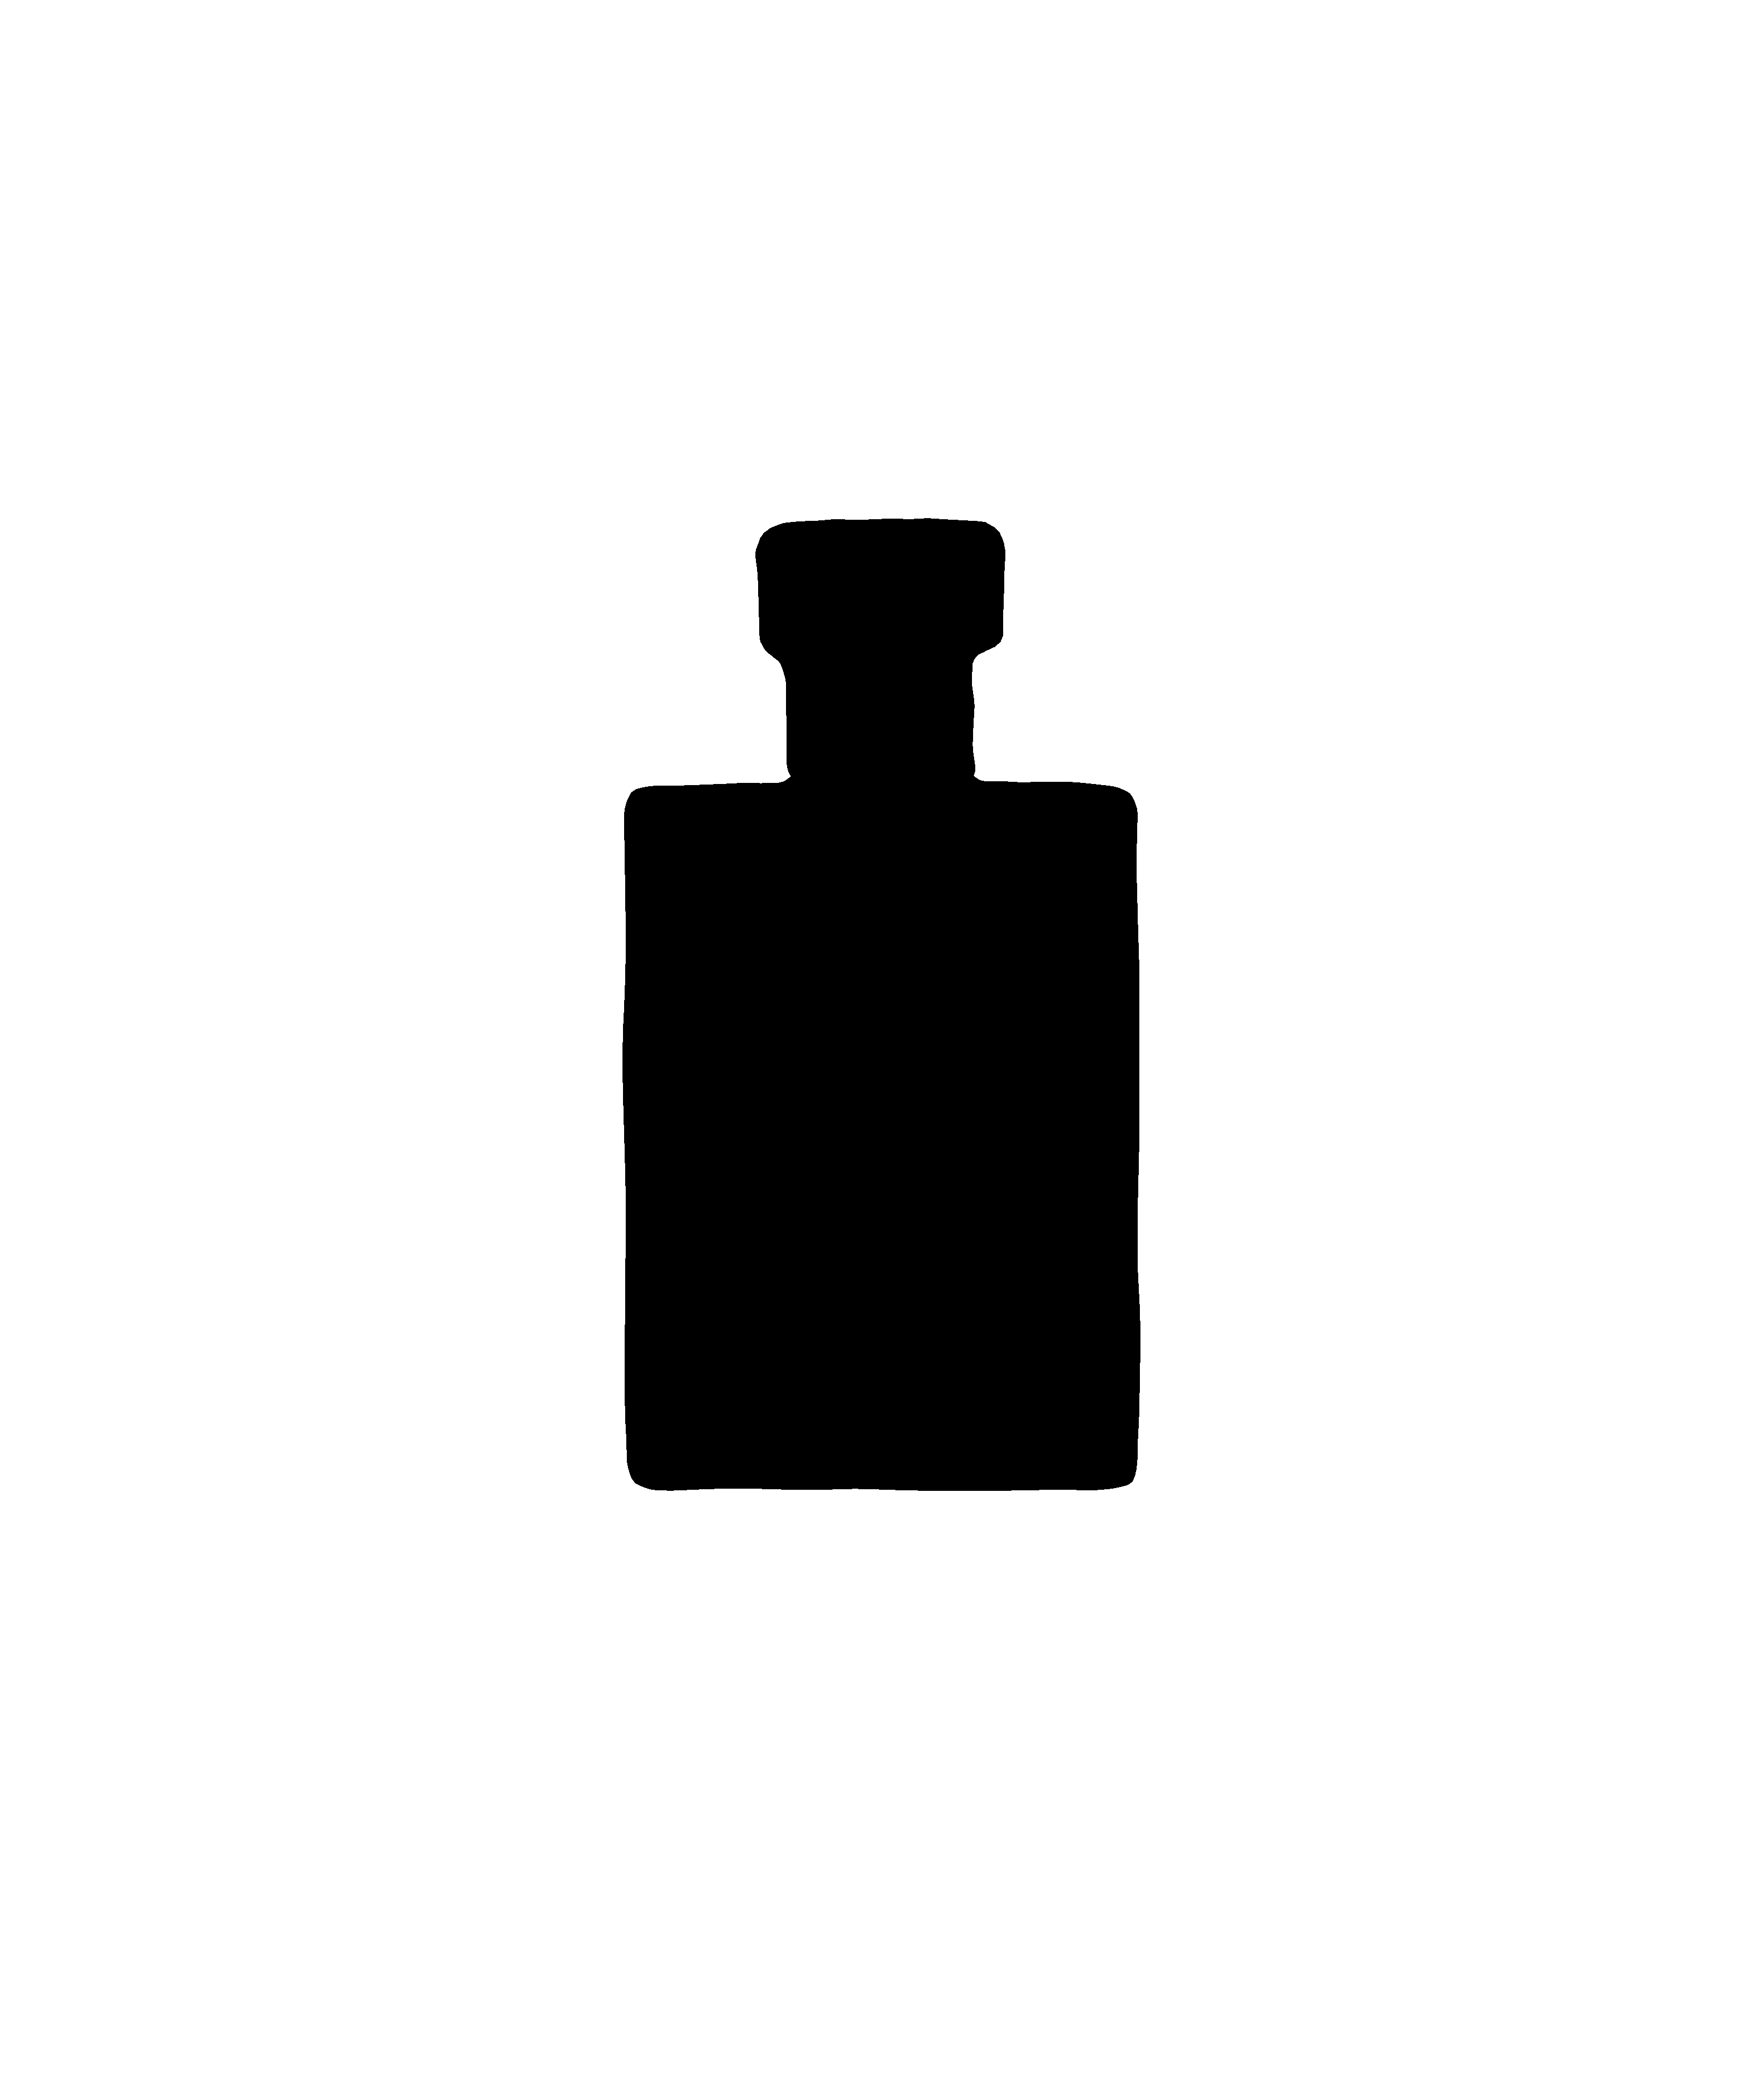

In [ ]:
im.show()

In [ ]:
import PIL

def decrease_resolution(image, new_width, new_height):
  """Decreases the resolution of an image.

  Args:
    image: The image to be resized.
    new_width: The new width of the image.
    new_height: The new height of the image.

  Returns:
    The resized image.
  """

  # Convert the image to a RGBA format.
  image = image.convert('RGBA')

  # Resize the image to the specified width and height.
  image = image.resize((new_width, new_height))

  return image



# Example usage with a new resolution of 300 DPI
image = im
new_image = decrease_resolution(image, 512,512)
image2 = PIL.Image.open("output.png")
new_image2 = decrease_resolution(image2, 512,512)

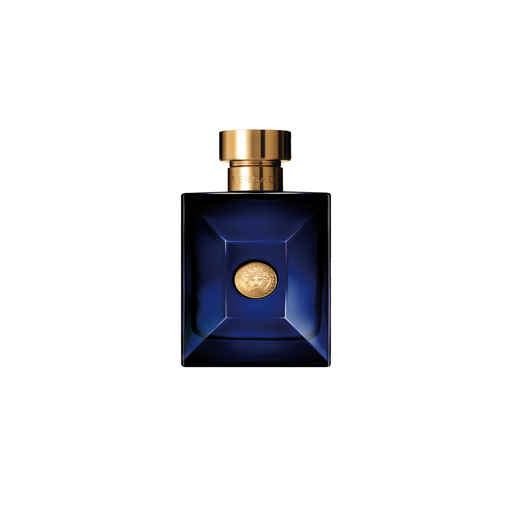

In [ ]:
new_image2.show()

In [ ]:
from diffusers import StableDiffusionInpaintPipeline

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting", torch_dtype=torch.float16, use_safetensors=True
)
pipe = pipe.to("cuda")
pipe.enable_attention_slicing()

prompt = "a portrait photo of a white marble table counter with pink walls background, dslr, natural shadow, natural light, sharp, in focus, 4k"
negative_prompt = "writing,people"
image = pipe(prompt=prompt, image=new_image2, mask_image=new_image,
        num_images_per_prompt=3).images


  0%|          | 0/50 [00:00<?, ?it/s]

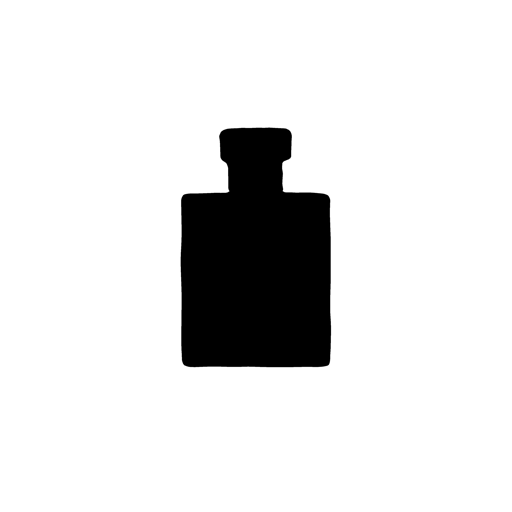

In [ ]:
new_image.show()

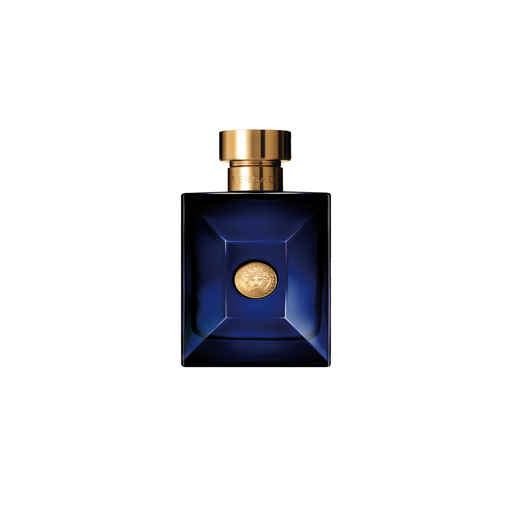

In [ ]:
new_image2.show()

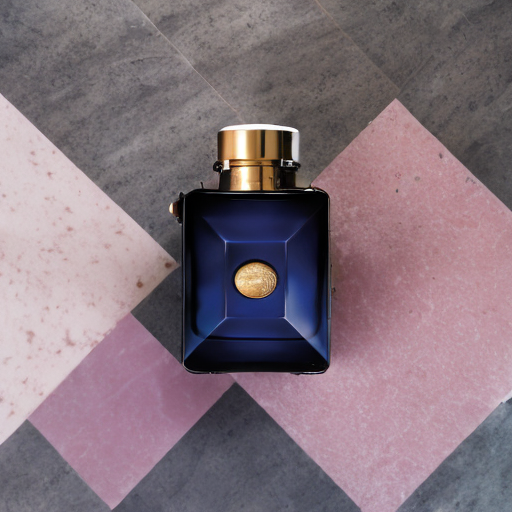

In [ ]:
image[1].show()

In [ ]:
from diffusers import KandinskyInpaintPipeline, KandinskyPriorPipeline

pipe_prior = KandinskyPriorPipeline.from_pretrained(
    "kandinsky-community/kandinsky-2-1-prior", torch_dtype=torch.float16
)
pipe_prior.to("cuda")
pipe_prior.enable_attention_slicing()

prompt = "a portrait photo of a white marble table counter with pink walls background, dslr, natural shadow, natural light, sharp, in focus, 4k"


prior_output = pipe_prior(prompt)

pipe = KandinskyInpaintPipeline.from_pretrained("kandinsky-community/kandinsky-2-1-inpaint", torch_dtype=torch.float16)
pipe.to("cuda")
pipe.enable_attention_slicing()

out = pipe(
    prompt,
    image=new_image2,
    mask_image=new_image),
    **prior_output,
    height=768,
    width=768,
    num_inference_steps=20,
)

out.images[0].show()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 3>:3                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_utils.py:1063 in            │
│ from_pretrained                                                                                  │
│                                                                                                  │
│   1060 │   │   │   │   loaded_sub_model = passed_class_obj[name]                                 │
│   1061 │   │   │   else:                                                                         │
│   1062 │   │   │   │   # load sub model                                                          │
│ ❱ 1063 │   │   │   │   loaded_sub_model = load_sub_model(                                        │
│   1064 │   │   │   │   │   library_name=library_name,                                            │
│   1065 │   │   │   │   │   class_name=class_name,                                                │
│   1066 │   │   │   │   │   importable_classes=importable_classes,                                │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_utils.py:451 in             │
│ load_sub_model                                                                                   │
│                                                                                                  │
│    448 │                                                                                         │
│    449 │   # check if the module is in a subdirectory                                            │
│    450 │   if os.path.isdir(os.path.join(cached_folder, name)):                                  │
│ ❱  451 │   │   loaded_sub_model = load_method(os.path.join(cached_folder, name), **loading_kwar  │
│    452 │   else:                                                                                 │
│    453 │   │   # else load from the root directory                                               │
│    454 │   │   loaded_sub_model = load_method(cached_folder, **loading_kwargs)                   │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/diffusers/models/modeling_utils.py:631 in                │
│ from_pretrained                                                                                  │
│                                                                                                  │
│   628 │   │   │   │   │   │   │   )                                                              │
│   629 │   │   │   │   │   │                                                                      │
│   630 │   │   │   │   │   │   if accepts_dtype:                                                  │
│ ❱ 631 │   │   │   │   │   │   │   set_module_tensor_to_device(                                   │
│   632 │   │   │   │   │   │   │   │   model, param_name, param_device, value=param, dtype=torc   │
│   633 │   │   │   │   │   │   │   )                                                              │
│   634 │   │   │   │   │   │   else:                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/accelerate/utils/modeling.py:161 in                      │
│ set_module_tensor_to_device                                                                      │
│                                                                                                  │
│    158 │   │   │   # For compatibility with PyTorch load_st

  0%|          | 0/25 [00:00<?, ?it/s]

You are using a model of type xlm-roberta to instantiate a model of type M-CLIP. This is not supported for all configurations of models and can yield errors.


  0%|          | 0/10 [00:00<?, ?it/s]

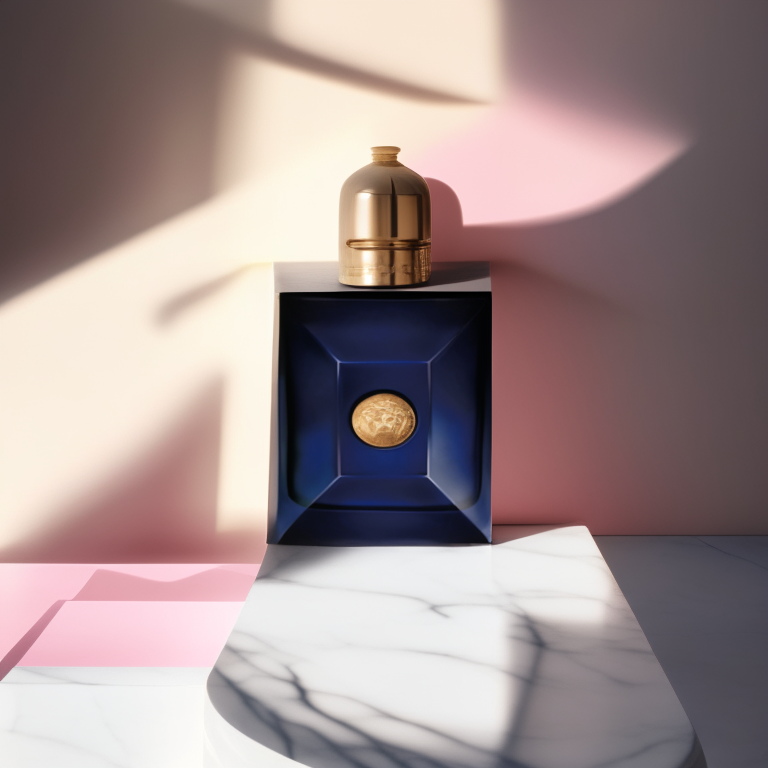

In [ ]:
import PIL

masked_im =pred_instance_map.numpy()
masked_im[masked_im == np.unique(pred_instance_map.numpy(), return_counts=True)[0][np.unique(pred_instance_map.numpy(), return_counts=True)[1].argmax()]] = 0
masked_im[masked_im != np.unique(pred_instance_map.numpy(), return_counts=True)[0][np.unique(pred_instance_map.numpy(), return_counts=True)[1].argmax()]] = 255

new_image = Image.fromarray(masked_im.astype('uint8')).convert("RGBA")
new_image = new_image.resize((512,512))

new_image2 = PIL.Image.open("output.png").resize((512,512))

from diffusers import KandinskyInpaintPipeline, KandinskyPriorPipeline

pipe_prior = KandinskyPriorPipeline.from_pretrained(
    "kandinsky-community/kandinsky-2-1-prior", torch_dtype=torch.float16
)
pipe_prior.to("cuda")
pipe_prior.enable_attention_slicing()

prompt = "a portrait photo of a white marble table counter with pink walls background, dslr, natural shadow, natural light, sharp, in focus, 4k"


prior_output = pipe_prior(prompt)

pipe = KandinskyInpaintPipeline.from_pretrained("kandinsky-community/kandinsky-2-1-inpaint", torch_dtype=torch.float16)
pipe.to("cuda")
pipe.enable_attention_slicing()

out = pipe(
    prompt,
    image=new_image2,
    mask_image=new_image,
    **prior_output,
    height=768,
    width=768,
    num_inference_steps=10,
)

out.images[0].show()


  0%|          | 0/50 [00:00<?, ?it/s]

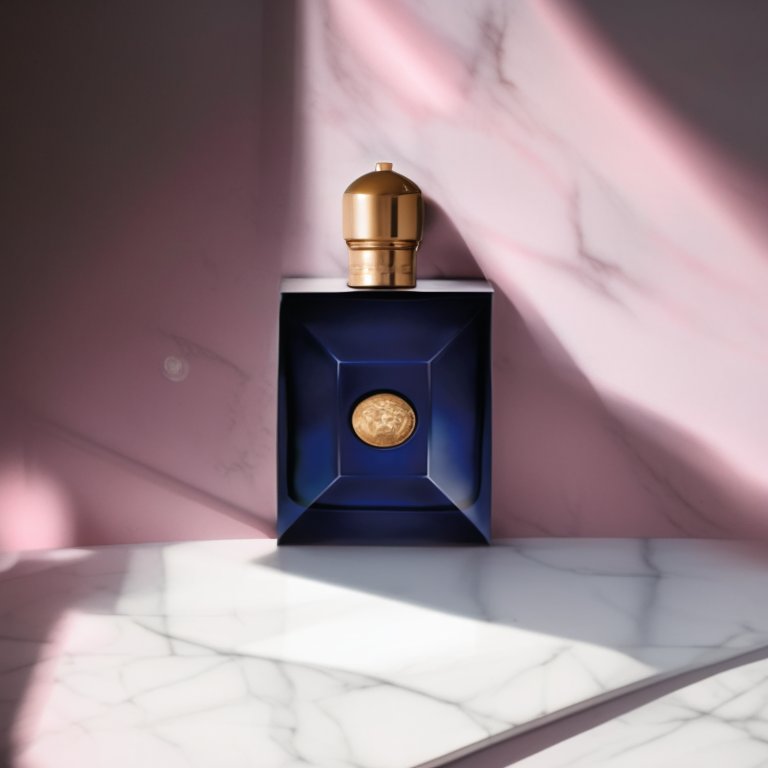

In [ ]:
out = pipe(
    prompt,
    image=new_image2,
    mask_image=new_image,
    **prior_output,
    height=768,
    width=768,
    num_inference_steps=50,
    guidance_scale= 2.0
)

out.images[0].show()

torch.Size([1920, 1920])


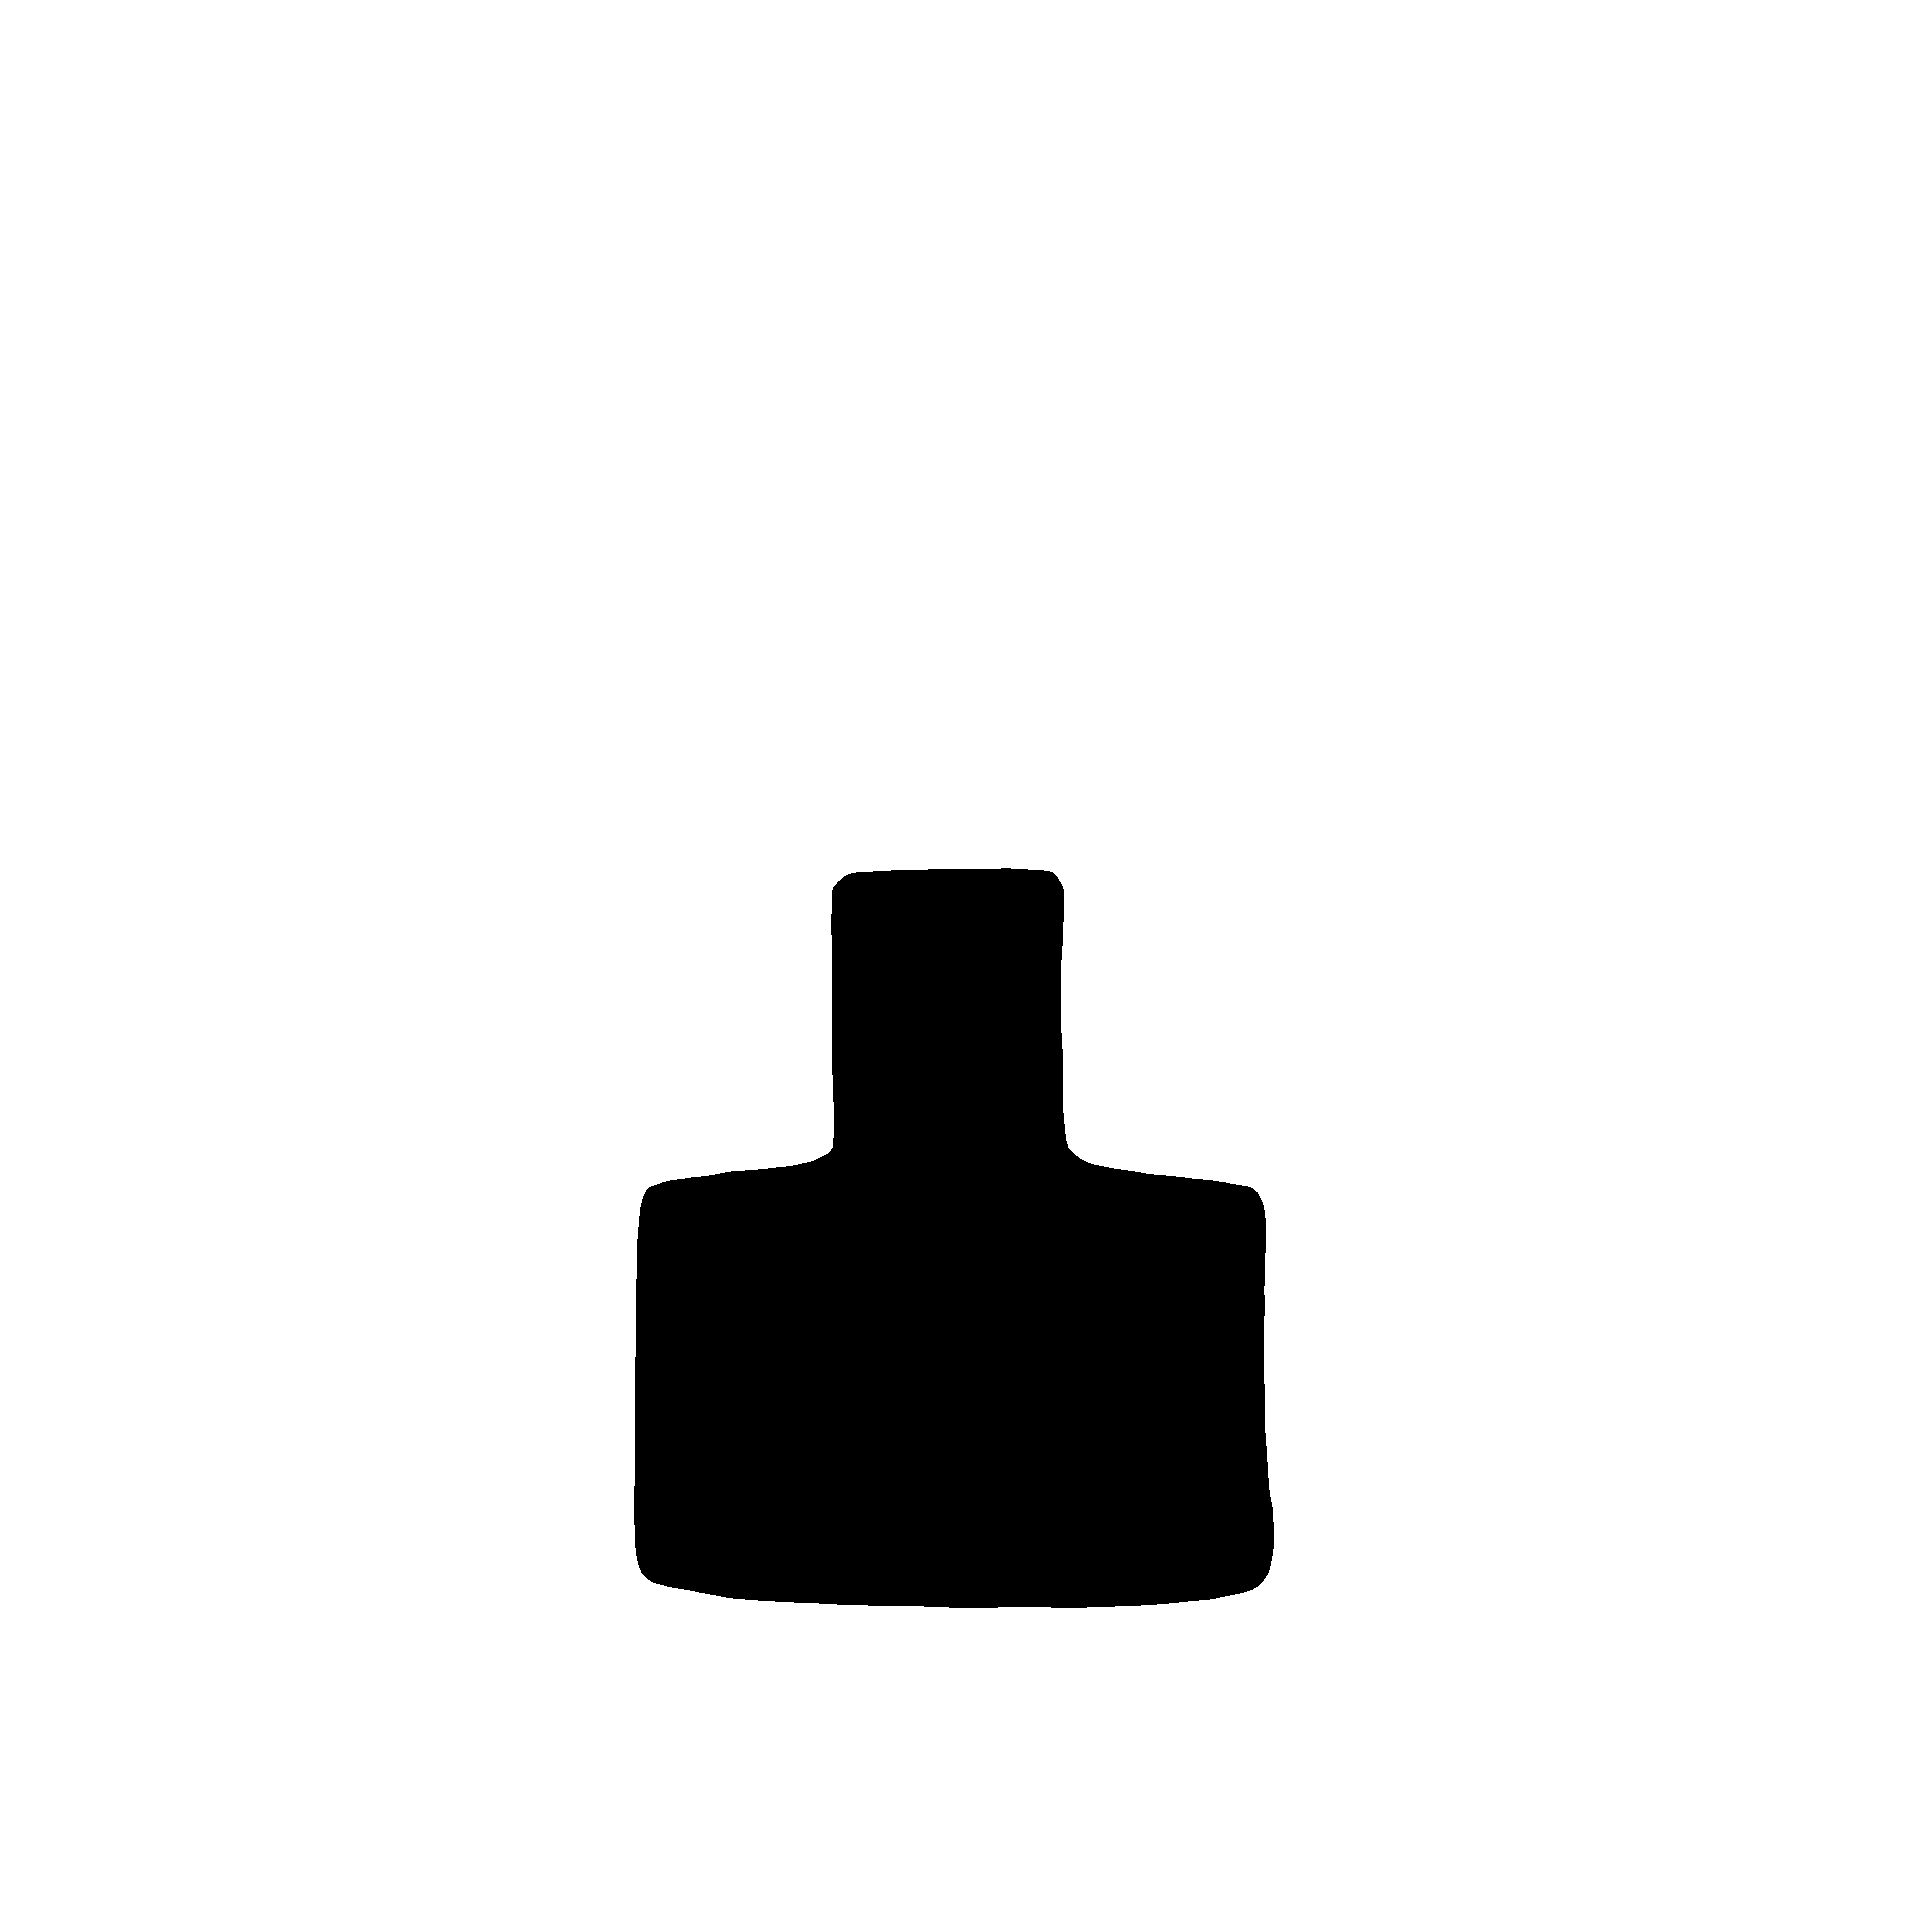

In [ ]:
image = Image.open("200630_colekt_pack0937__la_chambre__bottle_50ml__final__16x9-copy-scaled (1) (1).jpg")
inputs = image_processor(image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

# Model predicts class_queries_logits of shape `(batch_size, num_queries)`
# and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits

# Perform post-processing to get instance segmentation map
pred_instance_map = image_processor.post_process_semantic_segmentation(
    outputs, target_sizes=[image.size[::-1]]
)[0]
print(pred_instance_map.shape)

masked_im =pred_instance_map.numpy()
masked_im[masked_im == np.unique(pred_instance_map.numpy(), return_counts=True)[0][np.unique(pred_instance_map.numpy(), return_counts=True)[1].argmax()]] = 255
masked_im[masked_im == np.unique(pred_instance_map.numpy(), return_counts=True)[0][np.unique(pred_instance_map.numpy(), return_counts=True)[1].argmin()]] = 0

im = Image.fromarray(masked_im.astype('uint8')).convert("RGBA")
im.show()

  0%|          | 0/50 [00:00<?, ?it/s]

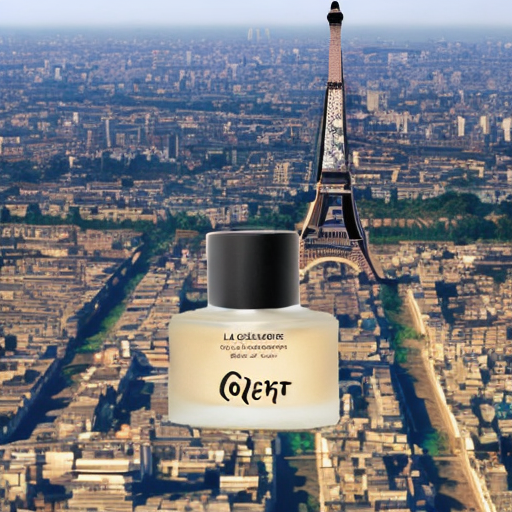

In [ ]:
image20 = im
new_image = decrease_resolution(image20, 512,512)
image21 = Image.open("200630_colekt_pack0937__la_chambre__bottle_50ml__final__16x9-copy-scaled (1) (1).jpg")
new_image2 = decrease_resolution(image21, 512,512)
prompt = "Eiffel tower in far background, mega buildings are in farest background, flying cars like birds, cyberpunk theme like Cyberpunk2077"
image = pipe(prompt=prompt, image=new_image2, mask_image=new_image).images[0]
image.show()